In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

np.random.seed(13)

## 1. MLP para regressão  

In [2]:
from sklearn.datasets import fetch_openml
concrete = fetch_openml(data_id='4353',as_frame=True)
X = concrete.data.iloc[:,0:8]
y = concrete.data.iloc[:,8]

In [3]:
X.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365.0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0


In [4]:
y.head()

0    79.99
1    61.89
2    40.27
3    41.05
4    44.30
Name: Concrete compressive strength(MPa. megapascals), dtype: float64

In [5]:
X = X.to_numpy()
y = y.to_numpy()

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

In [8]:
class Scaler():
    
    def __init__(self):
        self.max = None
        self.min = None
        
    def fit(self, data):
        self.max = data.max()
        self.min = data.min()
        
    def transform(self, data):
        return (data - self.min)/ (self.max-self.min)
    
    def inverse(self, data):
        return data * (self.max - self.min) + self.min

In [9]:

scaler_x = Scaler()
scaler_y = Scaler()

scaler_x.fit(x_train)
scaler_y.fit(y_train)

x_train_scaled = scaler_x.transform(x_train)
x_val_scaled = scaler_x.transform(x_val)

y_train_scaled = scaler_y.transform(y_train)
y_val_scaled = scaler_y.transform(y_val)

In [10]:
def tanh(u):
    return (np.exp(2*u) - 1)/(np.exp(2*u) + 1)

def tanh_dif(u):
    return 1 - np.tanh(u)**2  

def relu(u):
    return np.maximum(0, u)

def relu_dif(u):
    return (u >= 0) * 1.0 

def afim(z):
    return z

def afim_dif(z):
    return np.ones(shape=z.shape) 

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_dif(z):
    return sigmoid(z) * (1 - sigmoid(z))

def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)[None,:]

def softmax_dif(z):
    return softmax(z) * (1 - softmax(z))

def cost_mse(true, pred):
    return np.mean((true - pred)**2)

def cost_logistic(true, pred):
    return np.mean(- true * np.log(pred) - (1 - true) * np.log(1 - pred))

def cost_softmax(true, pred):
    return - np.sum(true * np.log(pred)) / len(true)

def RMSE(true, pred):
    return np.sqrt(np.mean((true - pred)**2))

In [11]:
class MLP_1L():
    
    def __init__(self, Nh=20, momentum=0.9, t=300, rate=0.0001, 
                 size_batch= 32, phi_1 = 'tanh', phi_2 = 'afim', cost = 'mse', reg = 0.1):
               
        self.t = t
        self.rate = rate
        self.B = size_batch
        self.lamb = reg
                
        self.W = None
        self.M = None
        self.D = None
        self.Nh = Nh
        self.momentum = momentum
        self.K = 1
        
        self.atv_1 = phi_1
        self.atv_2 = phi_2
        self.phi_1 = None
        self.phi_2 = None
        self.cost = cost
        self.f_cost = None
        
        self.costs = []
        self.costs_val = []
        
        if self.atv_1 == 'tanh':
            self.phi_1 = np.tanh                
            self.phi_1_dif = tanh_dif
            
        if self.atv_1 == 'relu':
            self.phi_1 = relu                
            self.phi_1_dif = relu_dif                         
                      
        if self.atv_2 == 'afim':
            self.phi_2 = afim          
            self.phi_2_dif = afim_dif
            self.f_cost = cost_mse
            
        if self.atv_2 == 'sigmoid':
            self.phi_2 = sigmoid                
            self.phi_2_dif = sigmoid_dif
            self.f_cost = cost_logistic
            
        if self.atv_2 == 'softmax': 
            self.phi_2 = softmax                
            self.phi_2_dif = softmax_dif
            self.f_cost = cost_softmax          
        
    def fit(self, X, y, X_val, y_val):
        if self.atv_2 == 'softmax':
            self.K = len(np.unique(y))
        n = X.shape[0]
        X = np.c_[np.ones(X.shape[0]), X]
        X_val = np.c_[np.ones(X_val.shape[0]), X_val]
        y = y.reshape(-1,1) 
        y_val = y_val.reshape(-1,1)
        self.D = X.shape[1]
    
        self.W = np.random.normal(loc= 0, scale=1,size=(self.Nh,self.D)) * np.sqrt(1/self.D)
        self.W[:,0] = 0
        self.M = np.random.normal(loc= 0, scale=1,size=(self.K, self.Nh+1)) * np.sqrt(1/self.Nh+1)
        self.M[:, 0] = 0
        W_past_increment = 0
        M_past_increment = 0 
                               
        for epoch in range(self.t):
            random_index = np.random.permutation(len(y))
            X = X[random_index]
            index = np.arange(0, n, self.B)
            index[-1] = n
            for i in range(len(index)-1):
                start = index[i]
                end = index[i+1]
                X_batch = X[start:end, : ]
                y_batch = y[start:end]
                Z = np.zeros([len(X_batch), self.Nh+1])
                
                Z[:, 0] = 1                            
                u = X_batch @ self.W.T
                Z[:, 1:] = self.phi_1(u)
                r = Z @ self.M.T
                pred = self.phi_2(r)
                
                error = y_batch - pred
                delta = error * self.phi_2_dif(r)              
                zeta =  self.phi_1_dif(u) * (delta @ self.M[:, 1:])
                term_M = self.lamb*self.M
                term_M[:, 0] = 0
                self.M = self.M + self.rate * (delta.T @ Z - term_M) +  self.momentum * M_past_increment
                M_past_increment = self.rate * (delta.T @ Z - term_M)
                term_W = self.lamb*self.W
                term_W[:,0] = 0
                self.W = self.W + self.rate * (zeta.T @ X_batch - term_W) + self.momentum * W_past_increment
                W_past_increment = self.rate * (zeta.T @ X_batch - term_W)
                
                Z = np.zeros([len(X), self.Nh+1])
                Z[:, 0] = 1                
                u = X @ self.W.T
                Z[:, 1:] = self.phi_1(u)
                r = Z @ self.M.T
                y_pred  = self.phi_2(r)                                 
                loss = self.f_cost(y, y_pred)/2
                self.costs.append(loss)
                
                Z = np.zeros([len(X_val), self.Nh+1])
                Z[:, 0] = 1                
                u = X_val @ self.W.T
                Z[:, 1:] = self.phi_1(u)
                r = Z @ self.M.T
                y_pred_val  = self.phi_2(r)        
                loss_val = self.f_cost(y_val, y_pred_val)/2
                self.costs_val.append(loss_val)
                
    def predict(self, X):
        
        X = np.c_[np.ones(X.shape[0]), X]        
        Z = np.zeros([len(X), self.Nh+1])
        Z[:, 0] = 1                
        u = X @ self.W.T
        Z[:, 1:] = self.phi_1(u)
        r = Z @ self.M.T
        y_pred  = self.phi_2(r)
        return y_pred

In [12]:
grid = {
    'Nh':[15 , 35 ,50,100],
    'rate':[0.0001 ,0.00001],
    'reg' : [0 ,0.01, 0.1, 0.25, 0.4]
    }

def RandomSearch(modelo, grid, qtd, cost):
    combinations = []
    while len(combinations) < qtd:
        a = {}
        for yi in grid.keys():
            a[yi] = np.random.choice(grid[yi])
            if a not in combinations:
                combinations.append(a)
                
    scores = []      
    for comb in combinations:
        model = modelo(**comb)
        model.fit(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled)
        y_pred = model.predict(x_val_scaled)
        y_pred = scaler_y.inverse(y_pred)
        scores.append(cost(y_val, y_pred))
        print(comb)
        print(cost(y_val, y_pred))
        print("----")
        
    scores = np.array(scores)
    best_index = np.argmin(scores)
    best = combinations[best_index]
        
    return best, combinations, scores
        

### Buscando os melhores parâmetros usando o conjunto de validação


In [13]:
best, combinations, scores = RandomSearch(MLP_1L, grid, 30, RMSE)

{'Nh': 50, 'rate': 0.0001, 'reg': 0.1}
16.876203906923152
----
{'Nh': 15, 'rate': 0.0001, 'reg': 0.1}
16.883259987299883
----
{'Nh': 15, 'rate': 1e-05, 'reg': 0.4}
19.176285535746445
----
{'Nh': 50, 'rate': 1e-05, 'reg': 0.1}
19.753723121178634
----
{'Nh': 15, 'rate': 0.0001, 'reg': 0.1}
16.92707012427224
----
{'Nh': 50, 'rate': 0.0001, 'reg': 0.1}
16.902458820833036
----
{'Nh': 35, 'rate': 1e-05, 'reg': 0.4}
18.484955315228166
----
{'Nh': 50, 'rate': 0.0001, 'reg': 0.25}
16.936022192953985
----
{'Nh': 35, 'rate': 1e-05, 'reg': 0.25}
18.090705678373986
----
{'Nh': 50, 'rate': 1e-05, 'reg': 0.25}
21.440945125885456
----
{'Nh': 35, 'rate': 0.0001, 'reg': 0.0}
17.22919477081492
----
{'Nh': 15, 'rate': 1e-05, 'reg': 0.0}
17.61643008108432
----
{'Nh': 15, 'rate': 0.0001, 'reg': 0.1}
16.855148018578937
----
{'Nh': 15, 'rate': 1e-05, 'reg': 0.25}
18.692598363938057
----
{'Nh': 35, 'rate': 0.0001, 'reg': 0.25}
16.909072685160556
----
{'Nh': 50, 'rate': 0.0001, 'reg': 0.01}
16.907556284935588
-

In [14]:
best

{'Nh': 15, 'rate': 0.0001, 'reg': 0.1}

In [15]:
np.argmin(scores)

12

### Performance para o conjunto de validação

In [16]:
def MSE(true, pred):
    return np.mean((true - pred)**2)

def MRE(y_true ,y_pred):
    return np.mean(np.abs((y_true - y_pred)/y_true))

In [17]:
model = MLP_1L(**best)

model.fit(x_train_scaled, y_train_scaled, x_val_scaled, y_val_scaled)
y_pred = model.predict(x_val_scaled)
y_pred = scaler_y.inverse(y_pred)


mre = MRE(y_val, y_pred)
RMSE = np.sqrt(MSE(y_val, y_pred))

print("MRE: {}".format(mre))
print("RMSE: {}".format(RMSE))

MRE: 0.599415239019777
RMSE: 17.058379804646563


**Curva de aprendizagem para treino e validação**

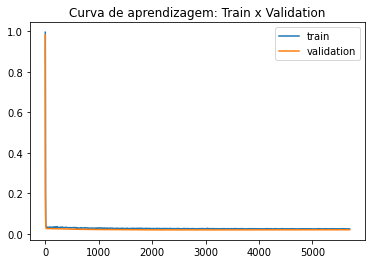

In [18]:
plt.plot(model.costs, label='train')
plt.plot(model.costs_val, label='validation')
plt.title("Curva de aprendizagem: Train x Validation")
plt.legend()

### Performance para o conjunto de treino

In [19]:
y_pred = model.predict(x_train_scaled)
y_pred = scaler_y.inverse(y_pred)


mre = MRE(y_train, y_pred)
RMSE = np.sqrt(MSE(y_train, y_pred))

print("MRE: {}".format(mre))
print("RMSE: {}".format(RMSE))


MRE: 0.6035854829370318
RMSE: 17.024373169986166


### Treinando o modelo usando treino e validação e avaliando no conjunto de teste

In [20]:
scaler_x.fit(x_train)
scaler_y.fit(y_train)

x_train_scaled  = scaler_x.transform(x_train)
x_val_scaled = scaler_x.transform(x_test)

y_train_scaled = scaler_y.transform(y_train)
y_val_scaled = scaler_y.transform(y_train)

In [21]:
model = MLP_1L(**best)

model.fit(x_train, y_train, x_val, y_val)
y_pred = model.predict(x_val)
y_pred = scaler_y.inverse(y_pred)


mre = MRE(y_test, y_pred)
RMSE = np.sqrt(MSE(y_test, y_pred))

print("MRE: {}".format(mre))
print("RMSE: {}".format(RMSE))

MRE: 90.28022559153679
RMSE: 2585.6030987887552


# 2. MLP para classificação (usando Sklearn)

In [22]:
from sklearn.datasets import fetch_openml
vowel = fetch_openml(data_id='307',as_frame=True)
X = vowel.data.iloc[:, 2:]
y = vowel.target

In [23]:
X.shape

(990, 10)

In [24]:
X.head()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9
0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814
1,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488
2,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049
3,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795
4,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396


In [25]:
y.head()

0    hid
1    hId
2    hEd
3    hAd
4    hYd
Name: Class, dtype: category
Categories (11, object): ['hid', 'hId', 'hEd', 'hAd', ..., 'hod', 'hUd', 'hud', 'hed']

In [26]:
import pandas as pd
y = pd.get_dummies(y, prefix='target')

In [27]:
y.head()

,target_hid,target_hId,target_hEd,target_hAd,target_hYd,target_had,target_hOd,target_hod,target_hUd,target_hud,target_hed
0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0


In [28]:
X = X.to_numpy()
y = y.to_numpy()

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1)

In [30]:
scaler_x = Scaler()

scaler_x.fit(x_train)

x_train_scaled = scaler_x.transform(x_train)
x_val_scaled = scaler_x.transform(x_val)

In [31]:
model = MLPClassifier(activation= 'relu',momentum= 0.9, hidden_layer_sizes= (75,),
                      max_iter= 20000,solver='sgd', learning_rate='adaptive', alpha=0.001)

In [32]:
model.get_params()

{'activation': 'relu',
 'alpha': 0.001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (75,),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 20000,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'sgd',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [33]:
model.fit(x_train_scaled, y_train)

MLPClassifier(alpha=0.001, hidden_layer_sizes=(75,), learning_rate='adaptive',
              max_iter=20000, solver='sgd')

In [34]:
y_pred = model.predict(x_val_scaled)

In [35]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_val, y_pred)
print(acc)

0.0
